In [13]:
model_path='/home/yutang/Downloads/model_woth_moel_new.pt'
num_experts=4
num_layers=3

In [14]:
import torch
import numpy as np
model = torch.load(model_path, map_location=torch.device('cpu'))
model_weight = model['model_state_dict']
keys = list(model_weight.keys())
print(keys)


['std', 'actor.0.weight', 'actor.0.bias', 'actor.2.router.weight', 'actor.2.router.bias', 'actor.2.noise_std.weight', 'actor.2.noise_std.bias', 'actor.2.experts.0.0.weight', 'actor.2.experts.0.0.bias', 'actor.2.experts.1.0.weight', 'actor.2.experts.1.0.bias', 'actor.2.experts.2.0.weight', 'actor.2.experts.2.0.bias', 'actor.2.experts.3.0.weight', 'actor.2.experts.3.0.bias', 'actor.3.router.weight', 'actor.3.router.bias', 'actor.3.noise_std.weight', 'actor.3.noise_std.bias', 'actor.3.experts.0.0.weight', 'actor.3.experts.0.0.bias', 'actor.3.experts.1.0.weight', 'actor.3.experts.1.0.bias', 'actor.3.experts.2.0.weight', 'actor.3.experts.2.0.bias', 'actor.3.experts.3.0.weight', 'actor.3.experts.3.0.bias', 'actor.4.router.weight', 'actor.4.router.bias', 'actor.4.noise_std.weight', 'actor.4.noise_std.bias', 'actor.4.experts.0.0.weight', 'actor.4.experts.0.0.bias', 'actor.4.experts.1.0.weight', 'actor.4.experts.1.0.bias', 'actor.4.experts.2.0.weight', 'actor.4.experts.2.0.bias', 'actor.4.exper

In [15]:
import seaborn as sns
import pandas as pd

frobs = []
for n in range(2, 2+num_layers, 1):
    params = []
    for i in range(num_experts):
        key = f'actor.{n}.experts.{i}.0.weight'
        params.append(model_weight[key].numpy())
    params = np.stack(params, axis=0)
    params_a = params[:, None, :, :]
    params_b = params[None, :, :, :]
    diff = (params_a - params_b)
    
    frobenius_norm = np.sqrt(np.trace(np.einsum('ijkm,ijml->ijkl', diff.transpose(0, 1, 3, 2), diff), axis1=2, axis2=3))
    frobs.append(frobenius_norm)

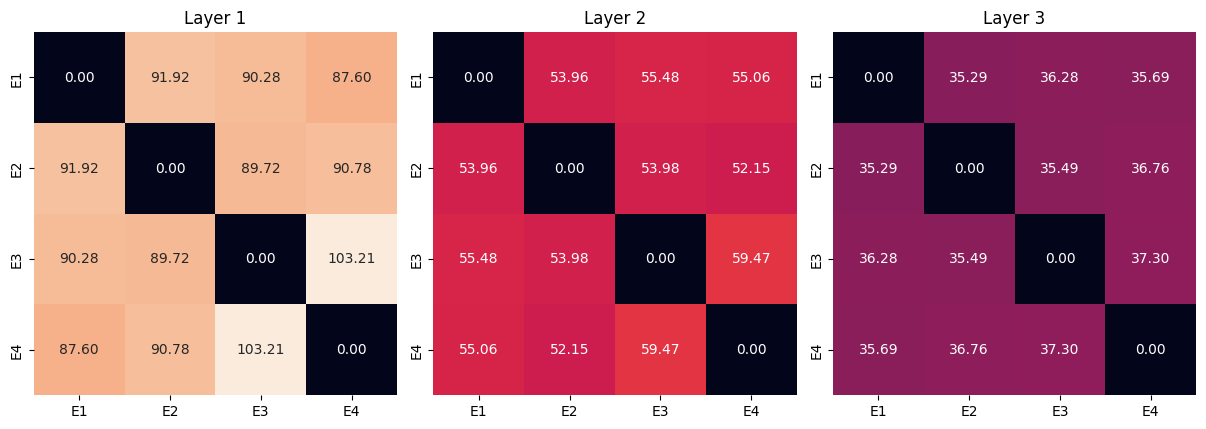

In [16]:
import matplotlib.pyplot as plt

stack_frobs = np.stack(frobs, axis=0)
v_min = np.min(stack_frobs)
v_max = np.max(stack_frobs)

plt.figure(figsize=(15, 5 * ((num_layers + 2) // 3)))
for layer_idx in range(num_layers):
    plt.subplot(((num_layers + 2) // 3), 3, layer_idx + 1)
    
    # Create DataFrame for current layer's frobenius norm
    df = pd.DataFrame(frobs[layer_idx], 
                     index=[f'E{i+1}' for i in range(num_experts)], 
                     columns=[f'E{i+1}' for i in range(num_experts)])
    
    # Create heatmap
    sns.heatmap(df, 
                cbar=False, 
                annot=True, 
                fmt='.2f', 
                vmin=v_min, 
                vmax=v_max, 
                square=True)
    
    plt.title(f'Layer {layer_idx + 1}')

plt.subplots_adjust(wspace=0.1, hspace=0.3)

In [17]:
import seaborn as sns
import pandas as pd

cosines = []
for n in range(2, 2+num_layers, 1):
    key = f'actor.{n}.router.weight'
    params = model_weight[key].numpy()
    params = params / np.linalg.norm(params, axis=-1, keepdims=True)

    diff = (params[:, None, :] * params[None, :, :]).sum(axis=-1)
    cosines.append(diff)

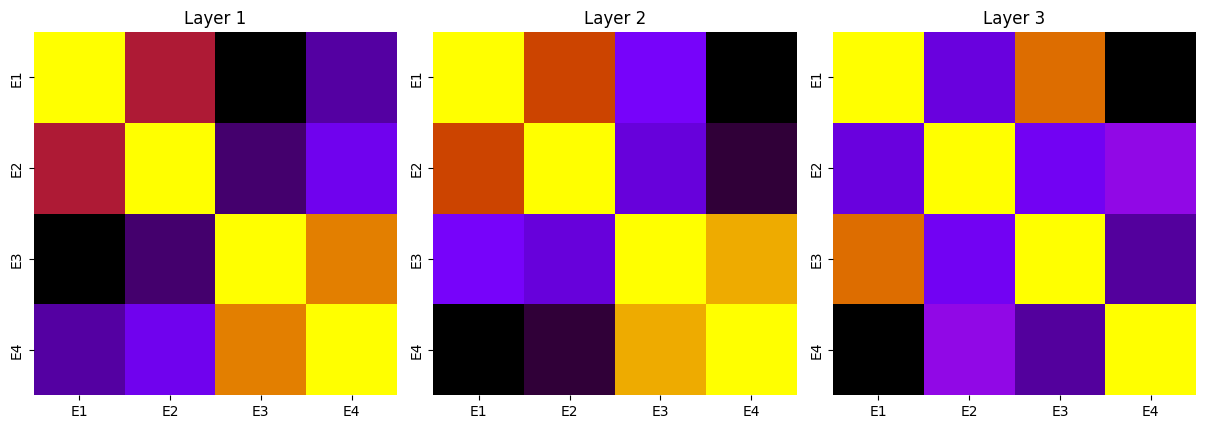

In [27]:
import matplotlib.pyplot as plt

stack_cosines = np.stack(cosines, axis=0)
v_min = np.min(stack_cosines)
v_max = np.max(stack_cosines)

plt.figure(figsize=(15, 5 * ((num_layers + 2) // 3)))
for layer_idx in range(num_layers):
    plt.subplot(((num_layers + 2) // 3), 3, layer_idx + 1)
    
    # Create DataFrame for current layer's frobenius norm
    df = pd.DataFrame(cosines[layer_idx] / v_max, 
                     index=[f'E{i+1}' for i in range(num_experts)], 
                     columns=[f'E{i+1}' for i in range(num_experts)])
    
    # Create heatmap
    sns.heatmap(df, cmap='cubehelix',
                cbar=False, 
                annot=False, 
                fmt='.2f', 
                square=True)
    
    plt.title(f'Layer {layer_idx + 1}')

plt.subplots_adjust(wspace=0.1, hspace=0.3)
plt.savefig('cosine_heatmap.png')